In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation
from numpy.random import normal

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

# 1D Day Model

In [ ]:
# Mp model by Reynolds et al
def MPder(y,t,p):  # return derivatives of the array y in MP model (reduced Reynolds) 

    der = np.array([p['sm']-p['mm']*y[0]-p['kmp']*y[0]*y[1],\
                    -p['kpm']*p['sm']*y[1]/(p['mm']+p['kmp']*y[1])\
                    +p['kpg']*y[1]*(1-y[1]/p['pinf'])])
    return der

MPpar= dict(kpg  = 0.6,kpm  = 0.6,kmp  = 0.01,kpn  = 1.8,knn  = 0.01,\
      knp  = 0.1,kdn  = 0.35,kcn  = 0.04,kcnd = 48.0,knd  = 0.02,\
      sm   = 0.005,snr  = 0.08,sc   = 0.0125,mm   = 0.002,mnr  = 0.12\
      ,mn   = 0.05,md   = 0.02,mc   = 0.1,xdn  = 0.06,pinf = 20.0,\
      cinf = 0.28)

# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 100
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        if plb.rand() > 0.5:
            yinit = 0.3 + plb.rand(2)*2
        else:
            yinit = plb.rand(2)*0.3
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    
# for fixed Delta t solve 300 trajectories

def traj_solve_noise(N,dt,mod,mod_par,var,noise):
    t0 = 0
    tend = 100
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        if plb.rand() > 0.5:
            yinit = 0.3 + plb.rand(2)*2
        else:
            yinit = plb.rand(2)*0.3
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    
    for i in range(N):
        for k in range(len(time)):
            for j in range(2):
                traj[i,k,j]= traj[i,k,j]*(1 + noise*normal(0., 1.))
            
    return traj,time 

## Example

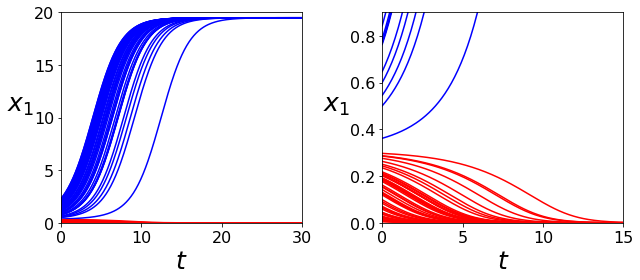

In [ ]:
N=100
traj,time = traj_solve(N,0.1,MPder,MPpar,0.0)
figure(figsize=(9,4))
for i in range(N):
    subplot(1,2,1)
    if traj[i,0,1]>0.3:
        plot(time[:],traj[i,:,1],'b')
    else:
        plot(time[:],traj[i,:,1],'r')
    xlabel("$t$",size='25')
    ylabel(r"$x_1$   ",size='25',rotation=0)
    tick_params(axis='both', which='major', labelsize=16)
    xlim((0,30))
    ylim((0,20))
    subplot(1,2,2)
    if traj[i,0,1]>0.3:
        plot(time[:],traj[i,:,1],'b')
    else:
        plot(time[:],traj[i,:,1],'r')
    xlabel("$t$",size='25')
    ylabel(r"$x_1$   ",size='25',rotation=0)
    tick_params(axis='both', which='major', labelsize=16)
    xlim((0,15))
    ylim((0,0.9))
tight_layout()    
#savefig("ofd/1d_traj.pdf",transparent=True)

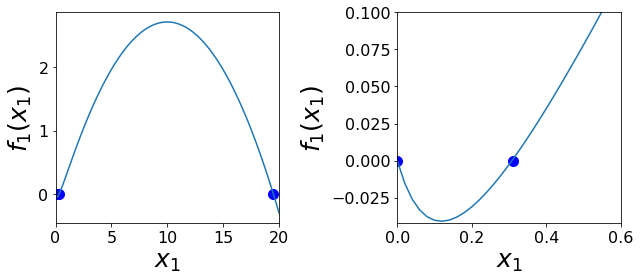

In [ ]:
figure(figsize=(9,4))
x = np.linspace(0,20,num=1000)
y = [MPder([1,i],1,MPpar)[1] for i in x]
subplot(1,2,1)
plot(x,y)
scatter([0,0.31,19.49],[0,0,0],marker='o',c='b',s=100)
xlabel("$x_1$",size='25')
ylabel("$f_1(x_1)$",size='25')
tick_params(axis='both', which='major', labelsize=16)
xlim(0,20)
subplot(1,2,2)
plot(x,y)
scatter([0,0.31],[0,0],marker='o',c='b',s=100)
xlabel("$x_1$",size='25')
ylabel("$f_1(x_1)$",size='25')
tick_params(axis='both', which='major', labelsize=16)
xlim(0,0.6)
ylim(-0.042,0.1)
tight_layout()    
#savefig("ofd/1d_model.pdf",transparent = True)

In [ ]:
pwd

'/Users/manuelmai/Documents/ODEs from data'

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder      

def traj_der_noise(traj,time,n):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt*(1+n*normal(0.0,1.))
                
    return trajder    

## Example

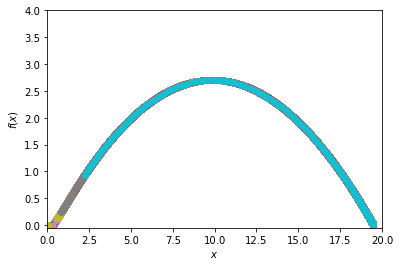

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,20))
    ylim((-0.05,4))

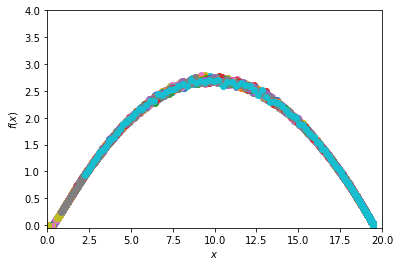

In [ ]:
trajder = traj_der_noise(traj,time,0.01)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,20))
    ylim((-0.05,4))

# Scale and discretize measurments to fit on a 256x1 grid

In [ ]:
#convert discrete index to x position in the model

#255 -> 20
#127 -> 0.6
#0->0
def ind_to_x(i):
    if i < 128:
        return i/127*0.6
    else:
        return (19.5 - 0.6)/128*i +0.6-127*18.9/128

In [ ]:
ind_to_x(255)

19.500000000000004

In [ ]:
# convert x position to discrete index

#20 -> 256
#0.6 -> 127
def x_to_ind(x):
    ind = 0
    if x <= 0.6:
        ind = int(round(x /0.6*127))
    else:
        ind = int(round((x-0.6+127/128*18.9)/(18.9/128)))
    return ind    

In [ ]:
def rec_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    from itertools import product as pd
    
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    touched = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, pd(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p
        touched[i:i + p_h, j:j + p_w] +=1

    #story checks out until here, I think    
    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            
            #img[i, j] /= float(min(i + 1, p_h, i_h - i) *
             #                  min(j + 1, p_w, i_w - j))
            img[i,j]/=float(touched[i,j])    
    return img

In [ ]:
int(round((19.5-0.6+127/128*18.9)/(18.9/128)))

255

In [ ]:
def traj_to_f_meas(traj,trajder):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,256),-100.)
    for k in range(N):
        for i in range(Nt-1):
            #make sure index fits into the 256 array
            if x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.) < 256:
                f_meas[k,x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)] = trajder[k,i,1]
    return f_meas 

def traj_to_f_m(traj,trajder,Ntraj,jj):
    N,Nt,Nvar = np.shape(traj)
    f_m = np.full((1,256),-100.)
    touched = np.full((256),0.)
    s = sorted(permutation(N)[:Ntraj])
    for k in s:
        for i in range(Nt-1):
            #make sure index fits into the 32x32x32array
            ind0 = x_to_ind((traj[k,i+1,jj]+traj[k,i,jj])/2.)
            if  (ind0 < 256) and (ind0 >= 0):
                if touched[ind0] == 0.:
                    f_m[0,ind0] = trajder[k,i,jj]
                else:    
                    f_m[0,ind0] += trajder[k,i,jj]
                        
                    touched[ind0] +=1.
                    
    for i in range(256):
        if touched[i]!=0.:
            f_m[0,i]/=float(touched[i])
    return f_m

(-1, 256)

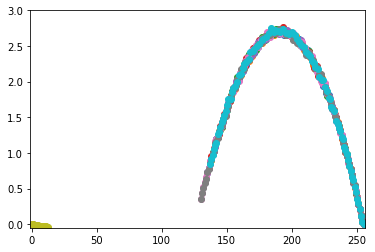

In [ ]:
f_meas = traj_to_f_meas(traj,trajder)
for i in range(10):
    plot(range(256),f_meas[i,:],'o')
ylim((-.05,3))
xlim((-1,256))

In [ ]:
f_m = traj_to_f_m(traj,trajder,100,1)

In [ ]:
f_m.shape

(1, 256)

(-0.5, 4)

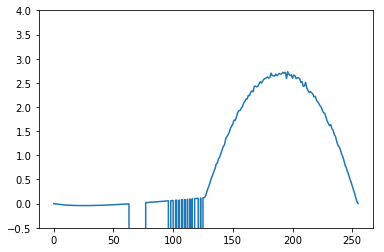

In [ ]:
plot(f_m[0,:])
ylim(-0.5,4)

# Sparsely reconstruct under-sampled data in basis

In [ ]:
from sklearn.linear_model import LassoLarsIC
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = False, aic=False):
    if not aic:
        clf = linear_model.Lasso(alpha=0.000004, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)
    else:
        model_aic = LassoLarsIC(criterion='aic')
    #create array for reconstructed data
    recdata = np.full(data.shape,0.)

    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                #print("not enough data!\n")
                #print(i)
                continue
        if not aic:        
            clf.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,clf.coef_)
        else:
            #print("here")
            model_aic.fit(basis[:,rm].T, data[i,rm])
            #(3) reconstruct patch from fit coefficients
            recdata[i,:] = np.dot(basis.T,model_aic.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata,np.count_nonzero(model_aic.coef_),model_aic.alpha_

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = False, aic=False):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    
    datarec,sp,lambd = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data,aic=aic)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = rec_from_patches_2d(datarec, imsize)
    return rec,sp,lambd

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)

    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((1,256),-100.)
    #average over each column and only those values that are not -100.
    for i in range(256):
        col = [f_meas[k,i] for k in s if f_meas[k,i]!= -100.]
        if col == []:
            f_m[0,i] = -100.
        else:
            f_m[0,i] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis,aic=False):
    b_size = init_basis.shape[1]
    #print(b_size)
    #reconstruct sparsely in random basis
    rec,sp,lambd = image_rec(f_m,init_basis,1,1,b_size,real_data = True,aic=aic)

    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=0.1, n_iter=5000 )
    # resize to basis size
    datarec = extract_patches_2d(rec, (1,b_size))
    datarec = datarec.reshape(datarec.shape[0], -1)

    V = tempdic.fit(datarec).components_
    rec,sp,lambd = image_rec(f_m,V,1,1,b_size,real_data = True,aic=aic)
    
    return V,rec,sp,lambd

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((1,256),0.)
for i in range(256):
    f_ref[0,i] = MPder([i,ind_to_x(i)],1,MPpar)[1]
Nave = 1
dt_list = [0.05,0.1,0.2,0.5,1,2,5]
Ntraj_list = [200]#[1,10,20,50,200]
b_size_list = [50]#[10,20,50,100,120,150,180,200]
res = np.full((len(dt_list)*len(Ntraj_list)*len(b_size_list),8),0.)   
k = -1
for b_size in b_size_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve(500,dt,MPder,MPpar,0.0)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        f_meas = traj_to_f_meas(traj,trajder)


        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+str(dt))
            print('Ntraj = '+str(Ntraj))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                r_basis = np.random.rand(100,b_size)
                f_m = traj_to_f_m(traj,trajder,Ntraj,1)
                # learn basis and reconstruct
                V,rec,sp,lambd = basis_and_rec(f_m,r_basis,aic=True)
                t_rec[i]=[norm_1(f_ref,rec),norm_2(f_ref,rec),norm_3(f_ref,rec)]
                
            res[k,:5] = [dt,Ntraj,b_size,sp,lambd]
            res[k,5:]= np.mean(t_rec,0)
            
            #np.savetxt("1d_err_dt_Ntraj_noise.txt",res)            

dt = 0.05
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=3.497e-05, previous alpha=1.093e-05, with an active set of 27 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=1.839e-04, previous alpha=1.575e-05, with an active set of 27 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=1.239e-04, previous alpha=1.370e-05, with an acti

dt = 0.1
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=7.118e-04, previous alpha=6.213e-05, with an active set of 29 regressors.
  ConvergenceWarning)


dt = 0.2
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 109 iterations, alpha=2.083e-05, previous alpha=5.881e-06, with an active set of 46 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=6.558e-05, previous alpha=1.401e-05, with an active set of 28 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.135e-04, previous alpha=1.136e-04, with an act

dt = 0.5
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 35 iterations, alpha=6.701e-05, previous alpha=4.459e-06, with an active set of 28 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=2.691e-06, previous alpha=2.387e-06, with an active set of 29 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=1.784e-04, previous alpha=1.777e-05, with an acti

dt = 1
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 36 iterations, alpha=6.295e-05, previous alpha=8.396e-06, with an active set of 29 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=2.448e-04, previous alpha=9.173e-06, with an active set of 29 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 40 iterations, alpha=4.907e-05, previous alpha=2.623e-05, with an acti

dt = 2
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 126 iterations, alpha=4.710e-04, previous alpha=1.253e-04, with an active set of 47 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 110 iterations, alpha=4.975e-04, previous alpha=3.860e-04, with an active set of 49 regressors.
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 108 iterations, alpha=1.593e-03, previous alpha=6.011e-04, with an a

dt = 5
Ntraj = 200


/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.142e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.142e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/manuelmai/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.142e-04, with an active set of 1 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/man

In [ ]:
res.shape

(7, 8)

# Data analysis

In [ ]:
res

NameError: name 'res' is not defined

In [ ]:
array([1,20,50,200])

array([   1.,    2.,    5.,   10.,   20.,   50.,  100.,  200.])

0
[]


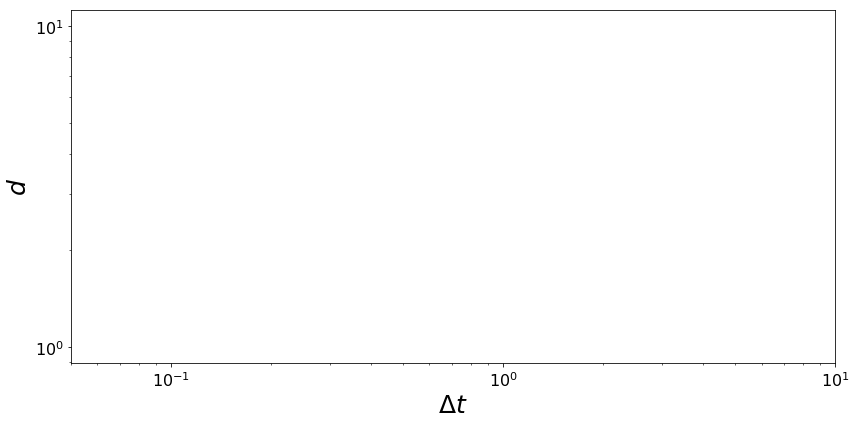

In [ ]:
#err_new = np.loadtxt("1d_err_dt_Ntraj_noise.txt")
err1 = np.loadtxt("1d_err_dt_Ntraj_new_1.txt")
err2 = np.loadtxt("1d_err_dt_Ntraj_new_2.txt")
err = np.concatenate((err2,err1),axis=0)

symb = ['o-','*-','>-','s-','D-','p-','^-','o--','*--','>--','s--','D--','p--','^--']
f = figure(figsize = (12,6))
#for i in np.unique(err[:,1]):
for k,i in enumerate(array([0.0,0.01,0.02,0.05,0.1,0.2,0.5,0.6,0.7,0.8,0.9])):
    #l = [j for j in range(len(err[:,0])) if (err[j,1]==i and err[j,2]==50)]
    l = [j for j in range(len(err_new[:,0])) if (err_new[j,1]==200 and  err_new[j,2]== 50)]
    #plot(err[l,0],err[l,3],symb[k],label = "$N_{traj}$ = "+str(int(i)))
    plot(err_new[l,0],err_new[l,5],symb[k],label = "$N_{traj}$ = "+str(int(i)))
    #title("1D Reconstruction",size = '30')
    #legend()
    xscale('log')
    xlim(0.05,10)
    #yscale('log')
    #ylim(0.000000001,2)
    xscale('log')
    xlim(0.05,10)
    yscale('log')
    xlabel('$\Delta t$',size = '25')
    ylabel('$d$',size = '25')
    tick_params(axis='both', which='major', labelsize=16) 
    print(k)
    print(l)
    break
tight_layout()
#f.savefig("ofd/1d_err_vs_dt_aic.pdf")

In [ ]:
err_new-res

NameError: name 'res' is not defined

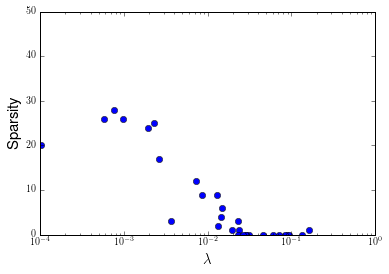

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plot(err_new[:,4],err_new[:,3],'o')
xscale('log')
ylim(0,50)
ylabel("Sparsity",size=15)
xlabel(r'\lambda',size=15)

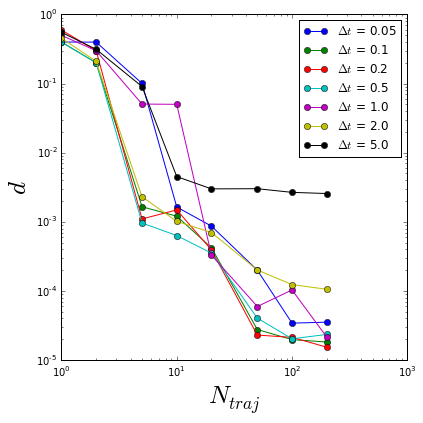

In [ ]:
f = figure(figsize = (6,6))
for i in np.unique(err[:,0]):   
    l = [j for j in range(len(err[:,0])) if (err[j,0]==i and err[j,2]==50)]
    plot(err[l,1],err[l,3],'o-',label = "$\Delta t$ = "+str(i))
    #title("1D Reconstruction",size = '30')
    legend()
    xscale('log')
    yscale('log')
    xlabel('$N_{traj}$',size = '25')
    ylabel('$d$',size = '25')
    
tight_layout()
f.savefig("ofd/1d_err_vs_Ntraj.pdf")

# Find optimal basis size

In [ ]:
#create reference function f_ref
f_ref = np.full((1,256),0.)
for i in range(256):
    f_ref[0,i] = MPder([i,ind_to_x(i)],1,MPpar)[1]
Nave = 20
dt_list = [1]#[0.1,0.2,0.5,1,2,5]
Ntraj_list = [10]#[1,2,5,10,15,20,50,100]
b_size_list = [1,5,10,20,30,30,40,50,60,70,80,90,100,110,120,130]
res = np.full((len(dt_list)*len(Ntraj_list)*len(b_size_list),6),0.)   
k = -1
for b_size in b_size_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve(300,dt,MPder,MPpar,0.0)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        f_meas = traj_to_f_meas(traj,trajder)


        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+str(dt))
            print('b_size = '+str(b_size))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                f_m,r_basis = f_prep(300,Ntraj,f_meas,b_size)
                # learn basis and reconstruct
                V,rec = basis_and_rec(f_m,r_basis,aic=True)
                t_rec[i]=[norm_1(f_ref,rec),norm_2(f_ref,rec),norm_3(f_ref,rec)]
                
            res[k,:3] = [dt,Ntraj,b_size]
            res[k,3:]= np.mean(t_rec,0)
            
np.savetxt("1d_err_vs_b_size_aic.txt",res)            

dt = 1
b_size = 1
dt = 1
b_size = 5
dt = 1
b_size = 10
dt = 1
b_size = 20


//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
#np.savetxt("1d_err_vs_b_size.txt",res)

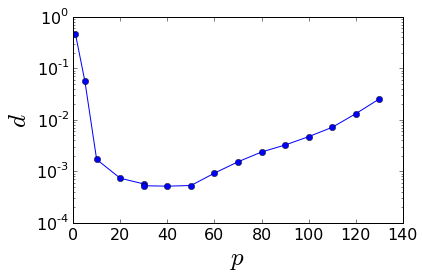

In [ ]:
err_bs = np.loadtxt("1d_err_vs_b_size.txt")
f = figure(figsize = (6,4))
plot(err_bs[:,2],err_bs[:,3],'o-')
yscale('log')
#title("1D Reconstruction",size = '30')
xlabel('$p$',size = '25')
ylabel('$d$',size = '25')
#ylim(-0.01,1)
tick_params(axis='both', which='major', labelsize=16) 
tight_layout()
f.savefig("ofd/1d_err_vs_b_size.pdf")

In [ ]:
plot(rec[0])

NameError: name 'plot' is not defined

# Find optimal $t_{end}$

In [ ]:
# alter traj_solve to include tend as input
def traj_solve_mod(N,dt,mod,mod_par,var,tend):
    t0 = 0
    #tend = 100
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        if plb.rand() > 0.5:
            yinit = 0.3 + plb.rand(2)*2
        else:
            yinit = plb.rand(2)*0.3
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time 

In [ ]:
#create reference function f_ref
f_ref = np.full((1,256),0.)
for i in range(256):
    f_ref[0,i] = MPder([i,ind_to_x(i)],1,MPpar)[1]
Nave = 20
b_size = 50
dt_list = [0.05,0.1,0.5]#[0.1,0.2,0.5,1,2,5]
Ntraj_list = [100]#[1,2,5,10,15,20,50,100]
tend_list = [1,2,3,4,5,6,7,8,9,10,20,50,100]
res = np.full((len(dt_list)*len(Ntraj_list)*len(tend_list),6),0.)   
k = -1
for tend in tend_list:
    for dt in dt_list:#:
        # generate trajectories
        traj,time = traj_solve_mod(300,dt,MPder,MPpar,0.0,tend)
        #generate derivatives
        trajder = traj_der(traj,time)
        #rescale to sample f
        f_meas = traj_to_f_meas(traj,trajder)


        #sample NTraj trajectories
        for Ntraj in Ntraj_list:
            print('dt = '+ str(dt))
            print('tend = '+str(tend))
            t_rec = np.full((Nave,3),0.)
            k+=1
            for i in range(Nave):
                f_m,r_basis = f_prep(300,Ntraj,f_meas,b_size)
                # learn basis and reconstruct
                V,rec = basis_and_rec(f_m,r_basis)
                t_rec[i]=[norm_1(f_ref,rec),norm_2(f_ref,rec),norm_3(f_ref,rec)]
                
            res[k,:3] = [dt,Ntraj,tend]
            res[k,3:]= np.mean(t_rec,0)

np.savetxt("1d_err_vs_tend.txt",res)             

NameError: name 'traj_solve_mod' is not defined

In [ ]:
res[0]

array([   0.1       ,  100.        ,    2.        ,    0.11405446,
         11.57937394,    0.51600804])

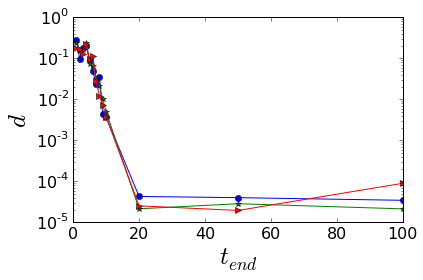

In [ ]:
res = np.loadtxt("1d_err_vs_tend.txt") 
symb = ['o-','*-','>-','s-','D-']
f = figure(figsize=(6,4))
for n,k in enumerate(np.unique(res[:,0])):
    l = [i for i in range(len(res[:,0])) if res[i,0]==k]
    plot(res[l,2],res[l,3],symb[n], label = '$\Delta t=$ '+str(k))
    #legend()
    #ylim(-0.01,0.05)
    xlabel("$t_{end}$",size = '25')
    ylabel('$d$',size = '25')
    yscale('log')
tick_params(axis='both', which='major', labelsize=16)    
tight_layout()    
f.savefig("ofd/1d_err_vs_tend.pdf")    